# HELIOS Demo
This notebook demonstrates the basic usage of the HELIOS simulation package.

The demo follows the optical path of a simulation:
1. **Scene observation** - Define astronomical objects and their spectral energy distributions
2. **Atmospheric effects** - Visualize and control atmospheric phase screens
3. **Telescope pupil** - Configure aperture geometry
4. **Coronagraphic masks** - Apply phase masks for high-contrast imaging

In [1]:
import sys
sys.path.insert(0, '../src')
import helios
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

## 1. Scene Observation
We start by creating a scene with a star and a planet. The distance to the system is defined at the Scene level.

In [2]:
scene = helios.Scene(distance=10*u.pc)

# Star at the center
star = helios.Star(temperature=5700*u.K, magnitude=5, mass=1*u.M_sun, position=(0*u.AU, 0*u.AU))

# Planet at 1 AU
planet = helios.Planet(mass=1*u.M_jup, position=(1*u.AU, 0*u.AU))

scene.add(star)
scene.add(planet)
# Add zodiacal and exozodiacal light components
zodi = helios.Zodiacal(brightness=0.5)
exozodi = helios.ExoZodiacal(brightness=0.3)
scene.add(zodi)
scene.add(exozodi)
print(f"Scene created with {len(scene.objects)} objects.")

Scene created with 4 objects.


### Scene Geometry
Visualize the spatial distribution of objects in the scene.

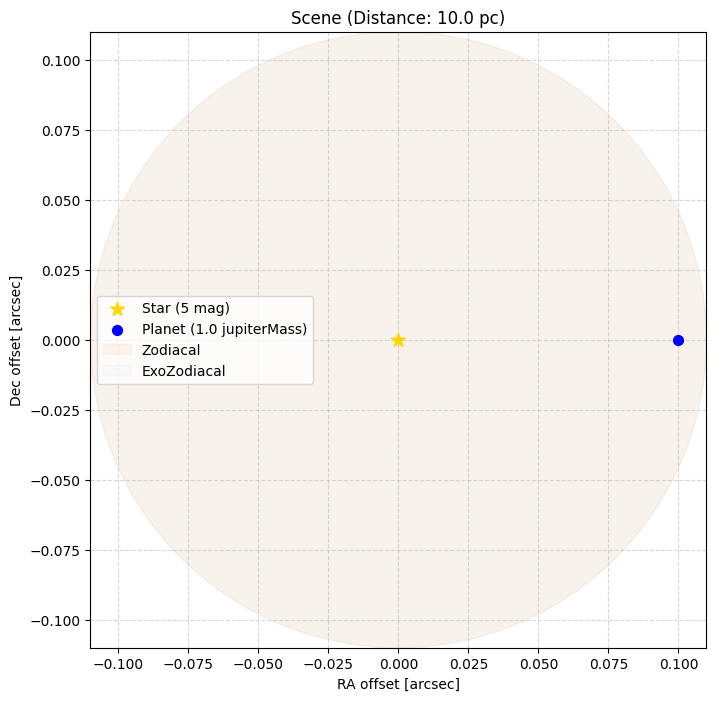

In [3]:
scene.plot()
plt.show()

### Spectral Energy Distributions (SEDs)
Plot the spectral energy distributions of the star and planet to understand their emission characteristics.

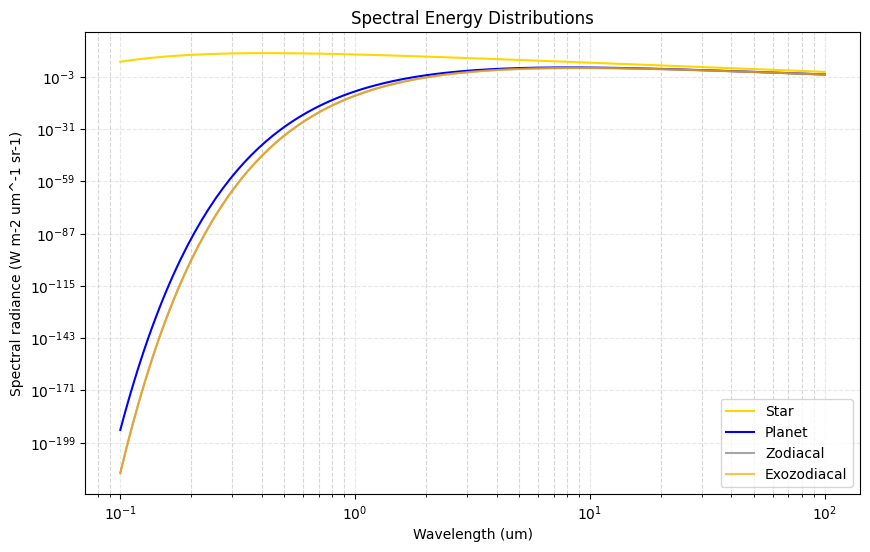

In [4]:
# Plot SEDs for star and planet
fig, ax = plt.subplots(figsize=(10, 6))
ax = star.plot_sed(ax=ax, color='gold', label='Star')
ax = planet.plot_sed(ax=ax, color='blue', label='Planet')
ax = zodi.plot_sed(ax=ax, color='gray', label='Zodiacal', alpha=0.7)
ax = exozodi.plot_sed(ax=ax, color='orange', label='Exozodiacal', alpha=0.7)
ax.set_title('Spectral Energy Distributions')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## 2. Atmospheric Phase Screen (Chromatic Aberrations)
The atmosphere introduces turbulent optical path difference (OPD) errors that are **chromatic** - the phase shift depends on wavelength: φ = 2π × OPD / λ.

This means shorter wavelengths (blue) experience larger phase aberrations than longer wavelengths (infrared) for the same atmospheric turbulence.

Temporal evolution is modeled via **frozen-flow turbulence** (Taylor hypothesis): turbulent screens drift at constant wind velocity.

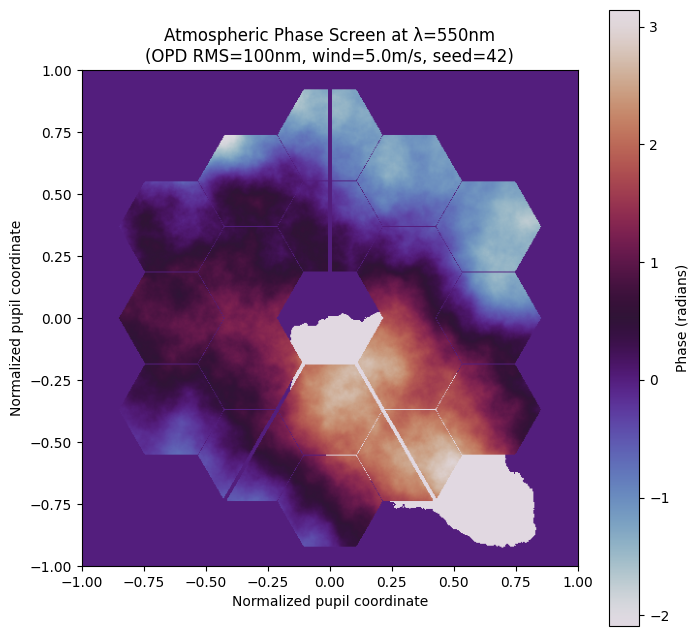

Phase RMS: 1.069 rad
Expected (2π×OPD/λ): 1.142 rad
Wind velocity: [5. 0.] m/s


In [5]:
# Create atmosphere with OPD in nanometers (NOT phase in radians!)
# Good seeing: 100nm RMS OPD, 5 m/s wind speed
seed = 42
atm = helios.Atmosphere(rms=100*u.nm, wind_speed=5*u.m/u.s, seed=seed)

# Generate a test wavefront to visualize the phase screen
wavelength = 550e-9 * u.m
N = 512
pupil_test = helios.Pupil.like('JWST')
p_amp = pupil_test.get_array(npix=N, soft=True)

# Create wavefront and apply atmosphere
wf = helios.Wavefront(wavelength=wavelength, size=N)
wf.field = p_amp.astype(np.complex128)
wf_atm = atm.process(wf, None)

# Extract and visualize the phase
phase = np.angle(wf_atm.field)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(phase, origin='lower', cmap='twilight', extent=[-1, 1, -1, 1])
ax.set_title(f'Atmospheric Phase Screen at λ={wavelength.to(u.nm).value:.0f}nm\n(OPD RMS={atm.rms*1e9:.0f}nm, wind={np.linalg.norm(atm.wind_velocity):.1f}m/s, seed={seed})')
ax.set_xlabel('Normalized pupil coordinate')
ax.set_ylabel('Normalized pupil coordinate')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Phase (radians)')
plt.show()

# Calculate phase RMS and verify chromaticity
phase_rms = np.std(phase[p_amp > 0.1])
expected_phase_rms = 2 * np.pi * atm.rms / wavelength.to(u.m).value
print(f"Phase RMS: {phase_rms:.3f} rad")
print(f"Expected (2π×OPD/λ): {expected_phase_rms:.3f} rad")
print(f"Wind velocity: {atm.wind_velocity} m/s")

### Temporal Evolution of Atmospheric Phase (Frozen-Flow Turbulence)
Simulate frozen-flow turbulence evolution: the turbulent screen drifts at constant wind velocity.
Different observation times sample different regions of the frozen turbulent volume. The SAME seed produces the same frozen turbulence, but different times show different "views" as the wind shifts the pattern.

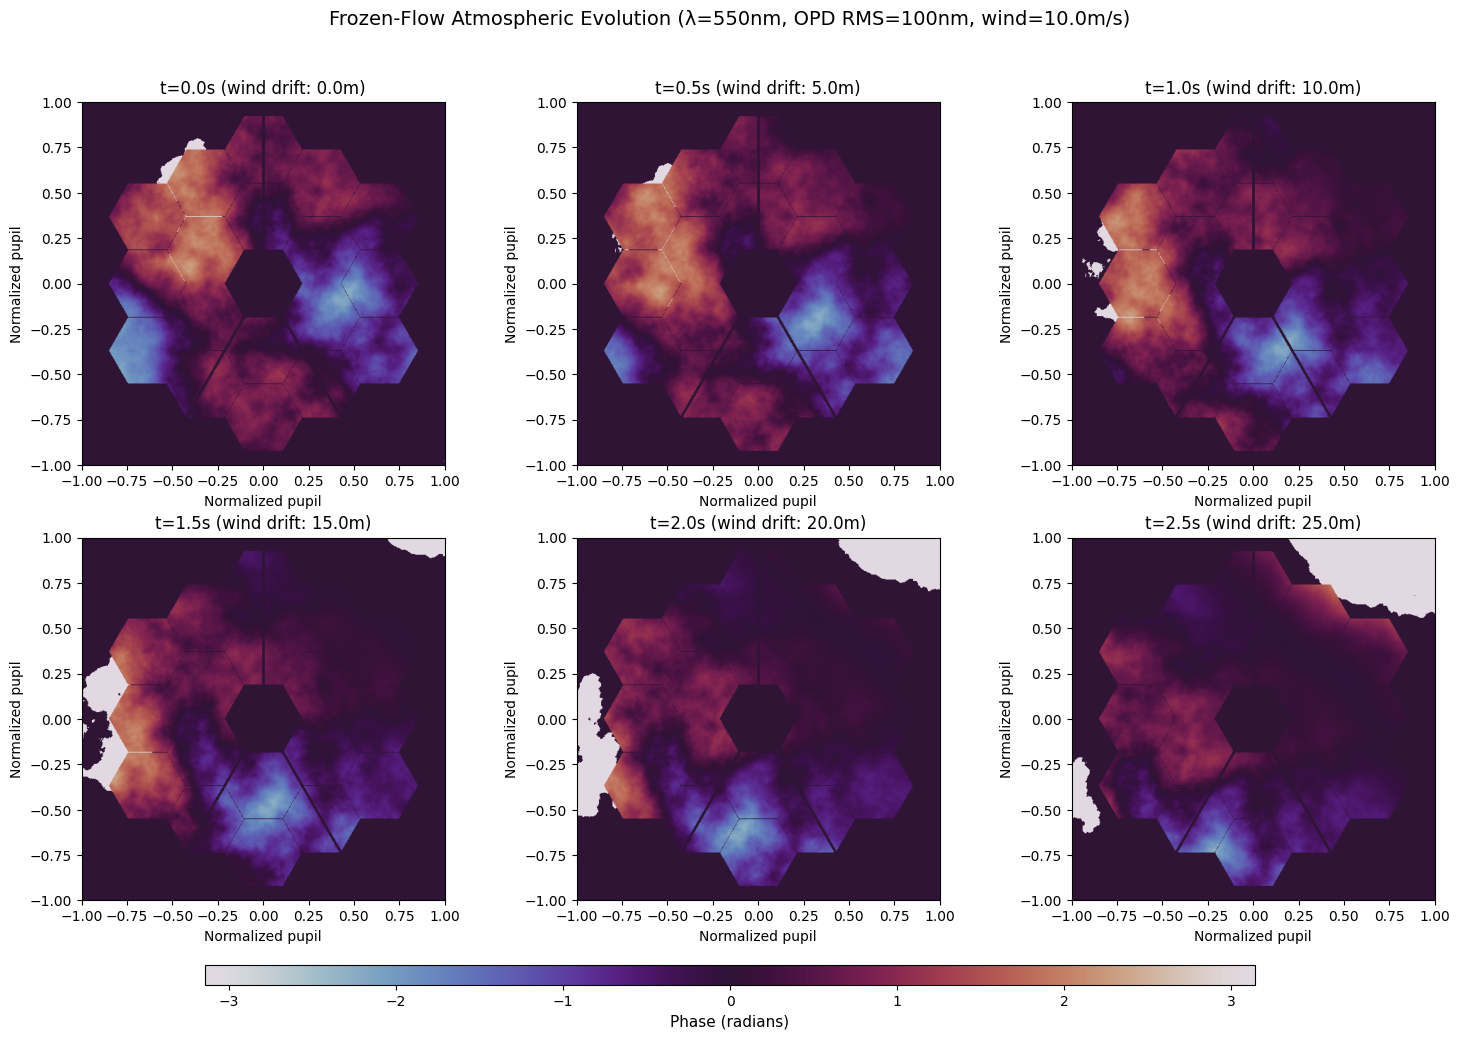

Same turbulent realization (seed=123), different times


In [6]:
# Frozen-flow temporal evolution with SAME atmospheric realization (same seed)
# but different observation times

# Mock context class to pass time information
class ObservationContext:
    def __init__(self, time):
        self.time = time

# Create atmosphere with fixed seed and wind
atm_flow = helios.Atmosphere(rms=100*u.nm, wind_speed=10*u.m/u.s, wind_direction=45, seed=123)

# Observation times (wind shifts the screen)
times = [0, 0.5, 1.0, 1.5, 2.0, 2.5]  # seconds

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, t in enumerate(times):
    # Create wavefront
    wf_t = helios.Wavefront(wavelength=wavelength, size=N)
    wf_t.field = p_amp.astype(np.complex128)
    
    # Apply atmosphere at time t
    ctx = ObservationContext(t*u.s)
    wf_t_atm = atm_flow.process(wf_t, ctx)
    
    # Extract phase
    phase_t = np.angle(wf_t_atm.field)
    
    # Plot
    im = axes[i].imshow(phase_t, origin='lower', cmap='twilight', 
                        vmin=-np.pi, vmax=np.pi, extent=[-1, 1, -1, 1])
    axes[i].set_title(f't={t:.1f}s (wind drift: {np.linalg.norm(atm_flow.wind_velocity)*t:.1f}m)')
    axes[i].set_xlabel('Normalized pupil')
    axes[i].set_ylabel('Normalized pupil')

# Add title before tight_layout
plt.suptitle(f'Frozen-Flow Atmospheric Evolution (λ={wavelength.to(u.nm).value:.0f}nm, OPD RMS={atm_flow.rms*1e9:.0f}nm, wind={np.linalg.norm(atm_flow.wind_velocity):.1f}m/s)', 
             fontsize=14, y=0.995)

# Adjust layout to make room for colorbar
plt.tight_layout(rect=[0, 0.05, 1, 0.97])

# Add shared colorbar at bottom
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Phase (radians)', fontsize=11)

plt.show()

print(f"Same turbulent realization (seed={atm_flow.seed}), different times")

## 3. Telescope Pupil Configuration
The telescope pupil defines the aperture geometry that collects light. HELIOS provides tools to construct custom pupils or use presets.

You can build pupils manually with geometric primitives (disks, spiders, segments) or load telescope presets (JWST, VLT, ELT).

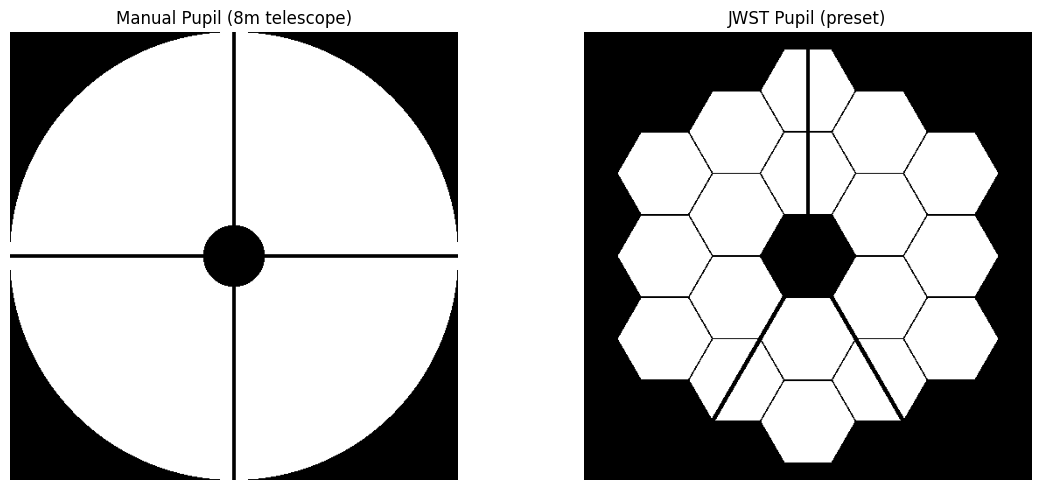

Manual pupil shape: (512, 512), fill factor: 0.757


In [7]:
# Manual pupil: simple 8-m class pupil with 4 spiders and central obscuration
p_manual = helios.Pupil(8*u.m)
p_manual.add_disk(radius=4.0 * u.m)
p_manual.add_central_obscuration(diameter=1.1 * u.m)
p_manual.add_spiders(arms=4, width=0.05 * u.m)

# Visualize the pupil
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
arr_manual = p_manual.get_array(npix=512)
axes[0].imshow(arr_manual, origin='lower', cmap='gray')
axes[0].set_title('Manual Pupil (8m telescope)')
axes[0].axis('off')

# JWST preset
p_jwst = helios.Pupil.like('JWST')
arr_jwst = p_jwst.get_array(npix=512)
axes[1].imshow(arr_jwst, origin='lower', cmap='gray')
axes[1].set_title('JWST Pupil (preset)')
axes[1].axis('off')

plt.tight_layout()
plt.show()
print(f"Manual pupil shape: {arr_manual.shape}, fill factor: {arr_manual.mean():.3f}")

### Diffraction Pattern
The pupil geometry determines the point spread function (PSF) via Fourier optics.

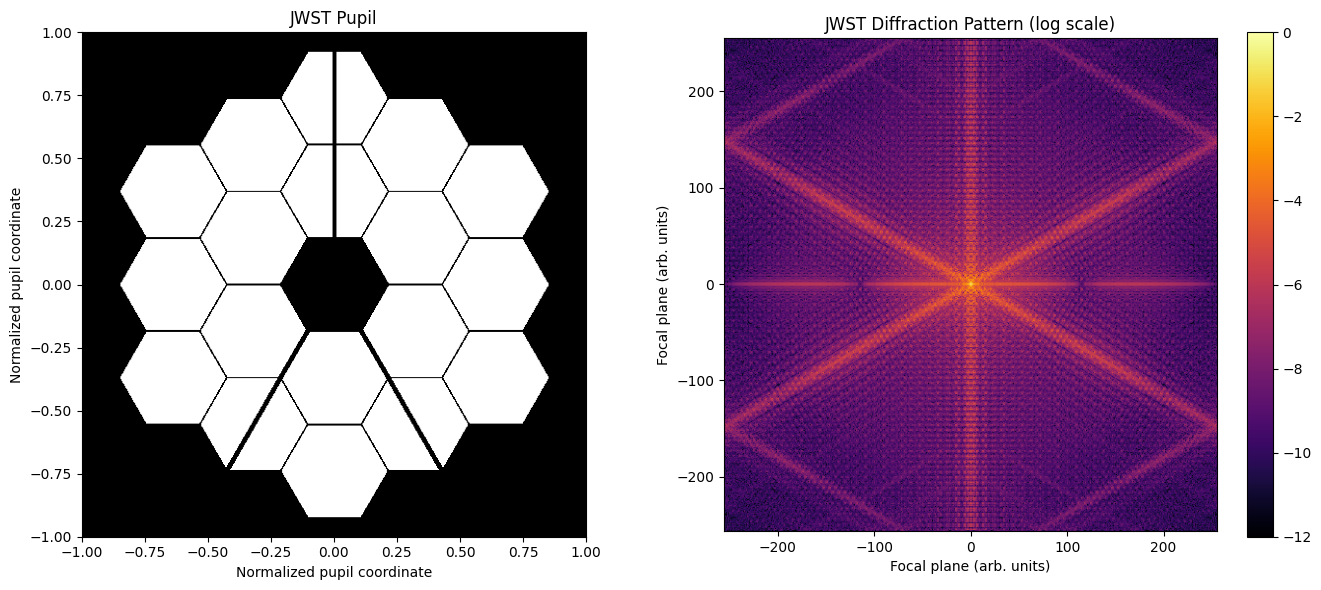

In [8]:
# Compute and display diffraction pattern for JWST pupil
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pupil amplitude
axes[0].imshow(arr_jwst, origin='lower', cmap='gray', extent=[-1, 1, -1, 1])
axes[0].set_title('JWST Pupil')
axes[0].set_xlabel('Normalized pupil coordinate')
axes[0].set_ylabel('Normalized pupil coordinate')

# Diffraction pattern (PSF)
axes[1] = p_jwst.plot_diffraction_pattern(npix=512, log=True, cmap='inferno', 
                                          wavelength=550e-9, ax=axes[1])
axes[1].set_title('JWST Diffraction Pattern (log scale)')

plt.tight_layout()
plt.show()

## 4. Coronagraphic Phase Masks
Coronagraphs use phase masks to suppress starlight and enhance the detection of faint companions. HELIOS supports vortex and 4-quadrant phase masks.

### Visualize Phase Masks
Phase masks modulate the wavefront in the focal plane to suppress on-axis light.

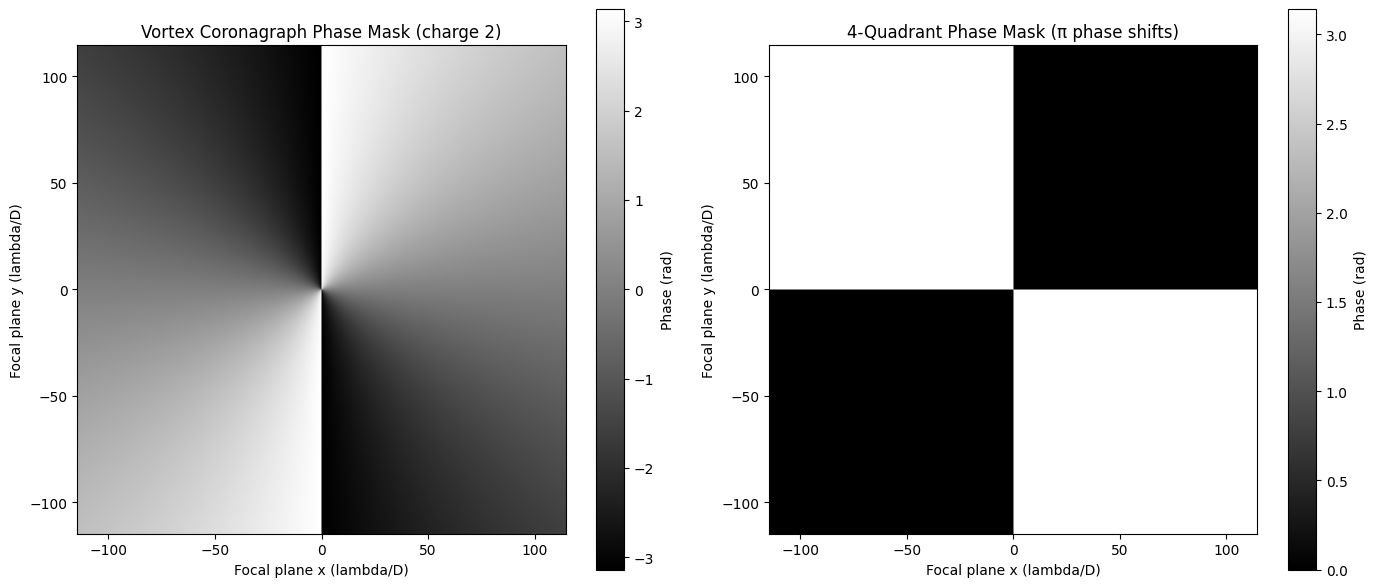

In [9]:
# Physical parameters
lam = 550e-9 * u.m
D = 6.5 * u.m
fov = 4 * u.arcsec

# Create coronagraph instances
coro_vortex = helios.Coronagraph(phase_mask='vortex')
coro_4q = helios.Coronagraph(phase_mask='4quadrants')

# Plot phase masks side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Vortex mask
axes[0] = coro_vortex.plot_mask(npix=512, kind='vortex', charge=2, 
                                lam=lam, diameter=D, fov=fov, 
                                display='lambda/d', ax=axes[0])
axes[0].set_title('Vortex Coronagraph Phase Mask (charge 2)')

# 4-quadrant mask
axes[1] = coro_4q.plot_mask(npix=512, kind='4quadrants', 
                            lam=lam, diameter=D, fov=fov, 
                            display='lambda/d', ax=axes[1])
axes[1].set_title('4-Quadrant Phase Mask (π phase shifts)')

plt.tight_layout()
plt.show()

### Coronagraphic Imaging
Apply coronagraphic masks to the rendered scene to suppress starlight and reveal the planet.

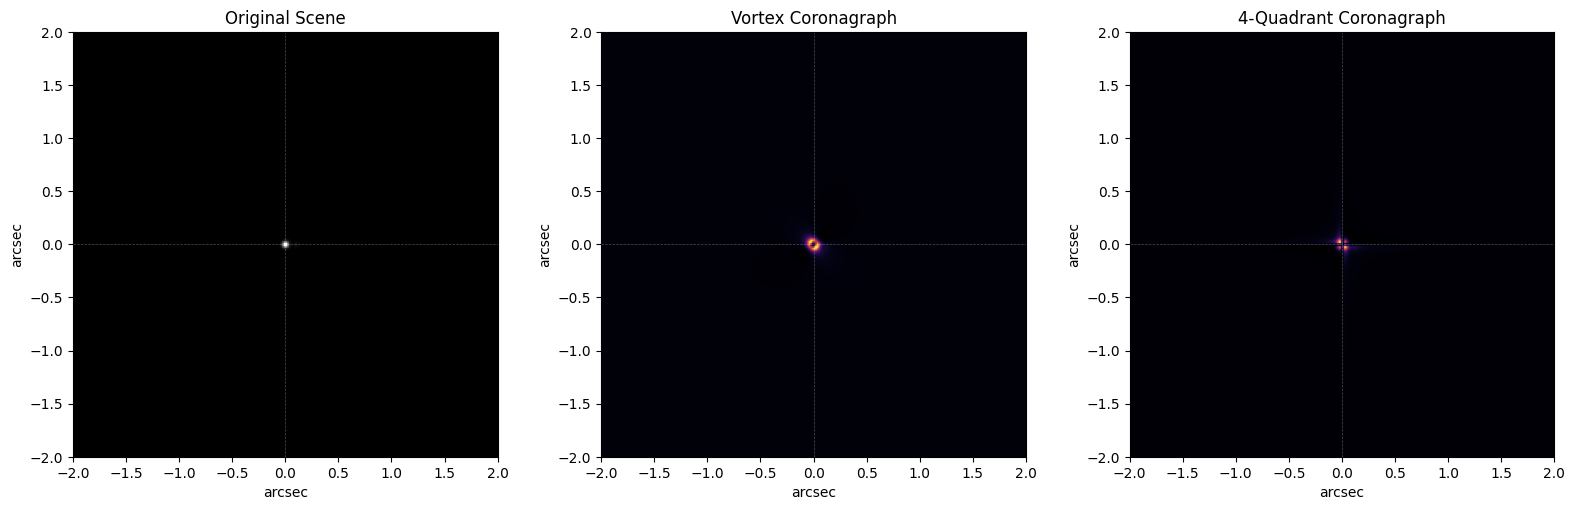

Scene dynamic range: 2.0e+01
Vortex suppression: 1.6e+02x


In [10]:
# Render the scene to an image
scene_img, x, y = scene.render(npix=256, fov=4*u.arcsec, return_coords=True)
extent = [x[0].value, x[-1].value, y[0].value, y[-1].value]

# Apply coronagraphs
img_vortex = coro_vortex.image_from_scene(scene_img, soft=True, oversample=4, 
                                          normalize=True, lam=lam, diameter=D, fov=fov)
img_4q = coro_4q.image_from_scene(scene_img, soft=True, oversample=4, 
                                  normalize=True, lam=lam, diameter=D, fov=fov)

# Display comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(scene_img, origin='lower', cmap='gray', extent=extent)
axes[0].set_title('Original Scene')
axes[0].set_xlabel('arcsec')
axes[0].set_ylabel('arcsec')

axes[1].imshow(img_vortex, origin='lower', cmap='inferno', extent=extent)
axes[1].set_title('Vortex Coronagraph')
axes[1].set_xlabel('arcsec')
axes[1].set_ylabel('arcsec')

axes[2].imshow(img_4q, origin='lower', cmap='inferno', extent=extent)
axes[2].set_title('4-Quadrant Coronagraph')
axes[2].set_xlabel('arcsec')
axes[2].set_ylabel('arcsec')

for ax in axes:
    ax.axvline(0, color='white', ls='--', alpha=0.3, lw=0.5)
    ax.axhline(0, color='white', ls='--', alpha=0.3, lw=0.5)

plt.tight_layout()
plt.show()

print(f"Scene dynamic range: {scene_img.max()/scene_img.min():.1e}")
print(f"Vortex suppression: {scene_img.max()/img_vortex[128,128]:.1e}x")

## 5. Advanced: Atmosphere + Adaptive Optics

**Atmospheric degradation and correction**

The atmosphere degrades the PSF through phase aberrations. Adaptive optics (AO) can partially correct these aberrations.
Below we compare PSFs with different atmospheric strengths and AO correction levels.

All PSFs are normalized to the ideal (no-atmosphere) peak to visualize Strehl ratio: Strehl = peak_corrected / peak_ideal.

TypeError: AdaptiveOptics.__init__() got an unexpected keyword argument 'rms'

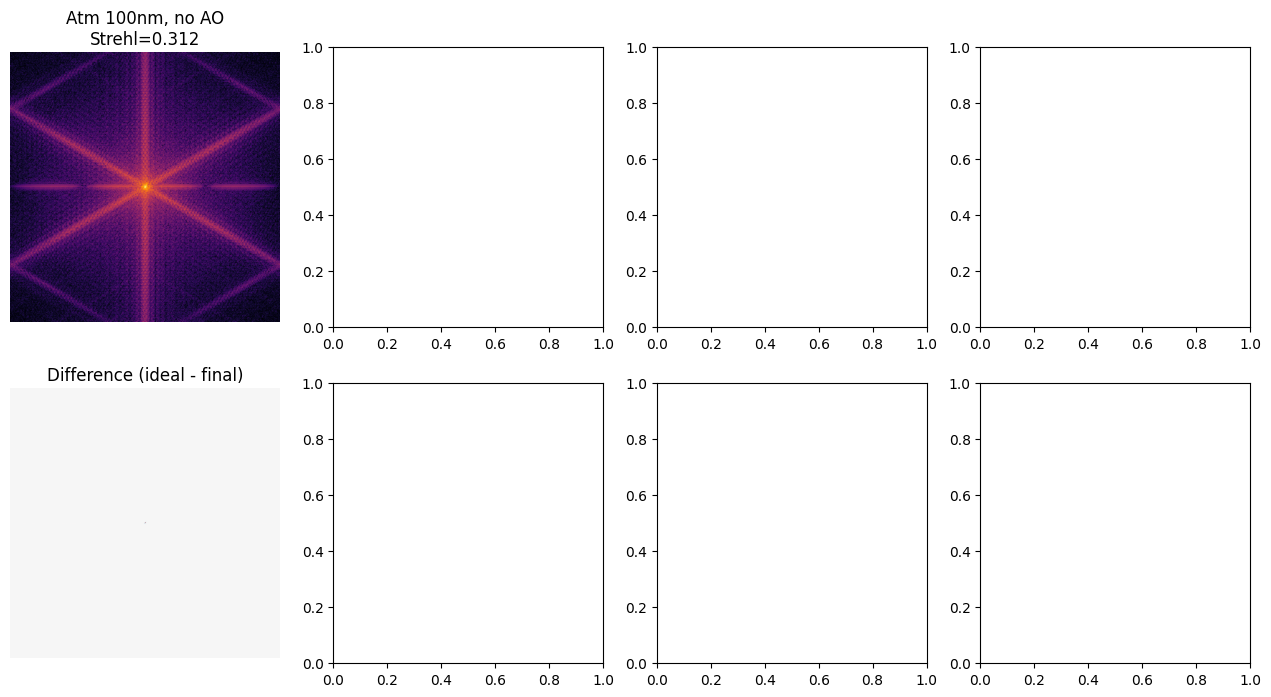

In [11]:
# Atmosphere + Adaptive Optics: compare multiple RMS strengths
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt

# wavelength and array size
wavelength = 550e-9 * u.m
N = 512

# build pupil amplitude (JWST-like)
pupil = helios.Pupil.like('JWST')
p_amp = pupil.get_array(npix=N, soft=True)

# compute ideal (no-atmosphere) PSF
wf_ideal = helios.Wavefront(wavelength=wavelength, size=N)
wf_ideal.field = p_amp.astype(np.complex128)
field_ideal = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(wf_ideal.field)))
psf_ideal = np.abs(field_ideal) ** 2
peak_ideal = psf_ideal.max()

# list of (atm_rms, ao_rms, subplot_title) tuples
test_cases = [
    (100e-9, 0, "Atm 100nm, no AO"),
    (100e-9, 80e-9, "Atm 100nm, AO 80nm"),
    (200e-9, 0, "Atm 200nm, no AO"),
    (200e-9, 150e-9, "Atm 200nm, AO 150nm"),
]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, (atm_rms, ao_rms, title) in enumerate(test_cases):
    # create wavefront
    wf = helios.Wavefront(wavelength=wavelength, size=N)
    wf.field = p_amp.astype(np.complex128)
    
    # apply atmosphere
    atm = helios.Atmosphere(rms=atm_rms * u.m)
    wf_atm = atm.process(wf)
    
    # optionally apply AO
    if ao_rms > 0:
        ao = helios.AdaptiveOptics(rms=ao_rms * u.m)
        wf_final = ao.process(wf_atm)
    else:
        wf_final = wf_atm
    
    # compute PSF
    field_final = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(wf_final.field)))
    psf_final = np.abs(field_final) ** 2
    
    # normalize all PSFs to ideal peak
    psf_norm_ideal = psf_ideal / peak_ideal
    psf_norm_final = psf_final / peak_ideal
    
    # compute Strehl (peak ratio)
    strehl = psf_final.max() / peak_ideal
    
    # difference map
    diff = psf_norm_ideal - psf_norm_final
    
    # plot final PSF
    axes[i].imshow(np.log10(psf_norm_final + 1e-10), origin='lower', cmap='inferno')
    axes[i].set_title(f"{title}\nStrehl={strehl:.3f}")
    axes[i].axis('off')
    
    # plot difference in the second row
    axes[i+4].imshow(diff, origin='lower', cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    axes[i+4].set_title("Difference (ideal - final)")
    axes[i+4].axis('off')

plt.tight_layout()
plt.show()

## 6. Full End-to-End Simulation
Putting it all together: Scene → Collectors → Camera.

In [ ]:
# Build a complete observation pipeline
collectors = helios.Collectors(latitude=0*u.deg, longitude=0*u.deg, altitude=2400*u.m)
pupil_obs = helios.Pupil(8*u.m)
collectors.add(size=8*u.m, shape=pupil_obs, position=(0,0))

camera = helios.Camera(pixels=(256, 256))

# Create context and add layers
context = helios.Context()
context.add_layer(scene)
context.add_layer(collectors)
context.add_layer(camera)

# Run the simulation
result = context.observe()
print(f"Simulation complete!")
print(f"Result shape: {result.shape}")
print(f"Result range: [{result.min():.2e}, {result.max():.2e}]")

Simulation complete. Result shape: (256, 256)
